In [137]:
import sys
sys.path.append("/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration")
import gain_utils as gu
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

folder = "/dipc/elena/WCTE_2025_commissioning/parquet_files"
run_number = "led_scan_calibration_20250404145411_hv_0_20250404145412_7"

df_wf = gu.load_waveforms(folder, run_number)
df_led = gu.load_led(folder, run_number)


In [138]:
df_wf.head()
df_wf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18472900 entries, 0 to 18472899
Data columns (total 16 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   flags             uint32
 1   chan              uint32
 2   num_samples       uint32
 3   num_bytes         uint32
 4   wave_no           uint32
 5   hit_no            uint32
 6   lsb_coarse        uint32
 7   msb_coarse        uint32
 8   coarse            uint64
 9   card_id           uint32
 10  pkt_num           uint32
 11  max_sample        int32 
 12  max_sample_pos    int32 
 13  sample_integral8  int32 
 14  samples           object
 15  card_mismatch     bool  
dtypes: bool(1), int32(3), object(1), uint32(10), uint64(1)
memory usage: 1.2+ GB


In [139]:
print(df_led.columns)
print(df_led.head(10))

Index(['led_no', 'gain', 'dac', 'seq_no', 'seq_type', 'lsb_coarse',
       'msb_coarse', 'coarse', 'card_id', 'pkt_num', 'card_mismatch'],
      dtype='object')
   led_no  gain  dac  seq_no  seq_type  lsb_coarse  msb_coarse      coarse  \
0       1     1  750    8873         0   660296486      141146  9250231078   
1       1     1  750    8874         0   660358986      141146  9250293578   
2       1     1  750    8875         0   660421486      141146  9250356078   
3       1     1  750    8876         0   660483986      141146  9250418578   
4       1     1  750    8877         0   660546486      141146  9250481078   
5       1     1  750    8878         0   660608986      141146  9250543578   
6       1     1  750    8879         0   660671486      141146  9250606078   
7       1     1  750    8880         0   660733986      141146  9250668578   
8       1     1  750    8881         0   660796486      141146  9250731078   
9       1     1  750    8882         0   660858986      141

In [140]:
card_id = 34
chan = 17

df_sel = df_wf[df_wf['card_id'] == card_id]
df_sel = df_sel[df_sel['chan'] == chan]

print(f"Selected {len(df_sel)} waveforms")

Selected 11127 waveforms


In [141]:
# Convert lists to 2D NumPy array: (n_waveforms, n_samples)
waveforms = np.stack(df_sel['samples'].to_numpy())
print("Waveforms shape:", waveforms.shape)   #waveforms with 32 samples this time 

Waveforms shape: (11127, 32)


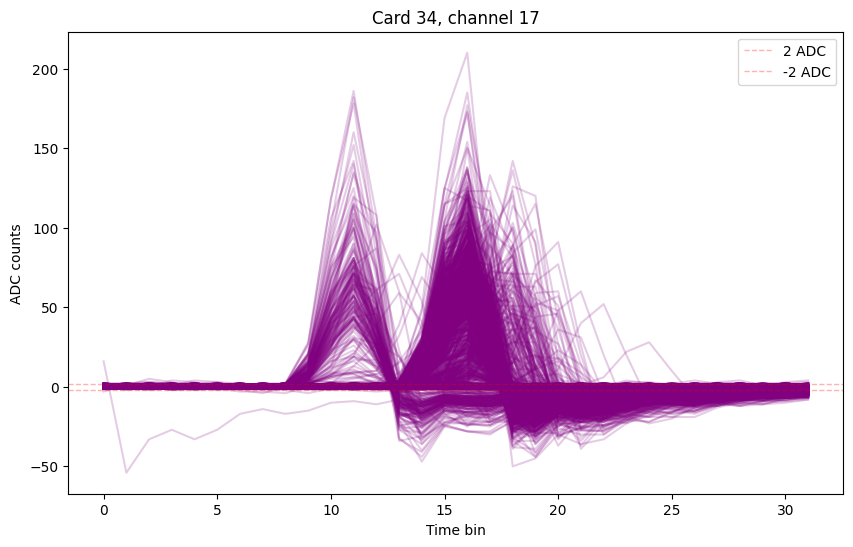

In [153]:
threshold = 2
plt.figure(figsize=(10,6))
for i in range(min(10000, waveforms.shape[0])):  
    plt.plot(waveforms[i], color='purple', alpha=0.2)
plt.axhline(y=threshold, color='red', alpha=0.3, linestyle='--', linewidth=1, label=f'{threshold} ADC')
plt.axhline(y=-threshold, color='red', alpha=0.3, linestyle='--', linewidth=1, label=f'-{threshold} ADC')
plt.xlabel("Time bin")
plt.ylabel("ADC counts")
plt.legend()
plt.title(f"Card {card_id}, channel {chan}")
plt.show()

In [154]:
#maximum absolute value for each waveform
max_abs_vals = np.max(np.abs(waveforms), axis=1)

signal_wfs = waveforms[max_abs_vals > threshold]
noise_wfs  = waveforms[max_abs_vals <= threshold]

print(f"Signal waveforms: {len(signal_wfs)}")
print(f"Noise waveforms: {len(noise_wfs)}")

Signal waveforms: 1203
Noise waveforms: 9924


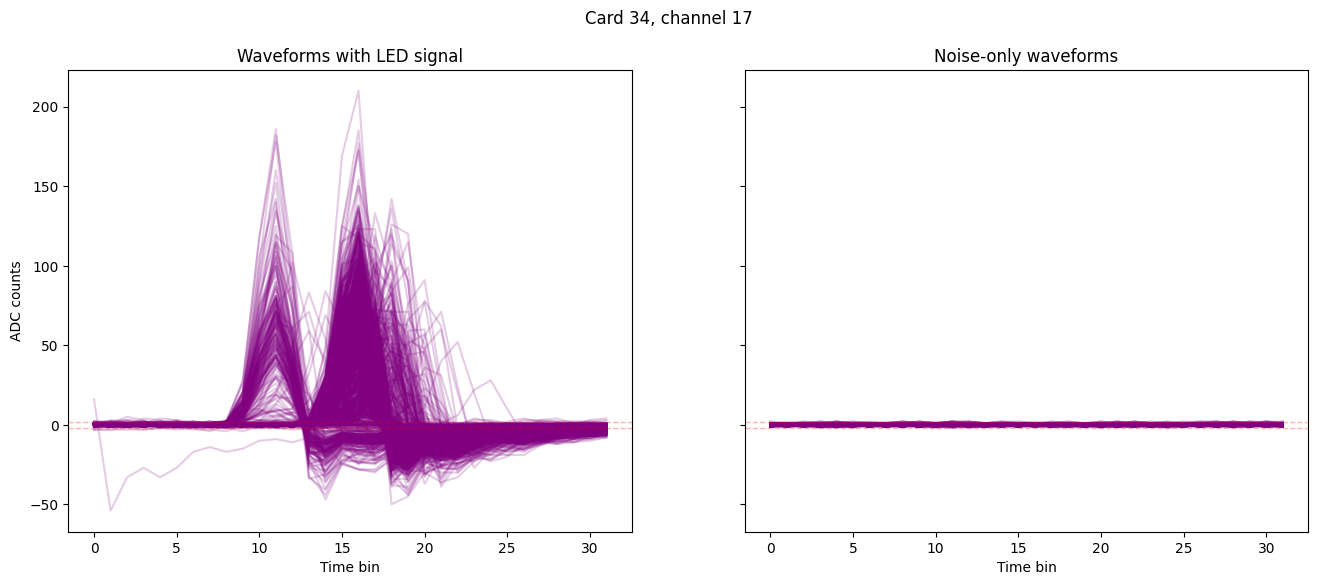

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(16,6), sharey=True)

#LED pulse(s)
for wf in signal_wfs[:10000]:  
    axs[0].plot(wf, color='purple', alpha=0.2)
axs[0].axhline(y=threshold, color='red', alpha=0.3, linestyle='--', linewidth=1)
axs[0].axhline(y=-threshold, color='red', alpha=0.3, linestyle='--', linewidth=1)
axs[0].set_xlabel("Time bin")
axs[0].set_ylabel("ADC counts")
axs[0].set_title("Waveforms with LED signal")

#noise-only
for wf in noise_wfs[:1000]:  
    axs[1].plot(wf, color='purple', alpha=0.2)
axs[1].axhline(y=threshold, color='red', alpha=0.3, linestyle='--', linewidth=1)
axs[1].axhline(y=-threshold, color='red', alpha=0.3, linestyle='--', linewidth=1)
axs[1].set_xlabel("Time bin")
axs[1].set_title("Noise-only waveforms")

plt.suptitle(f"Card {card_id}, channel {chan}")
plt.show()


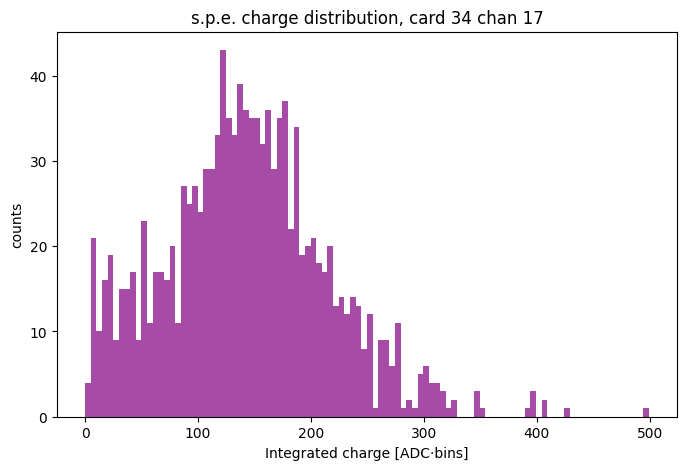

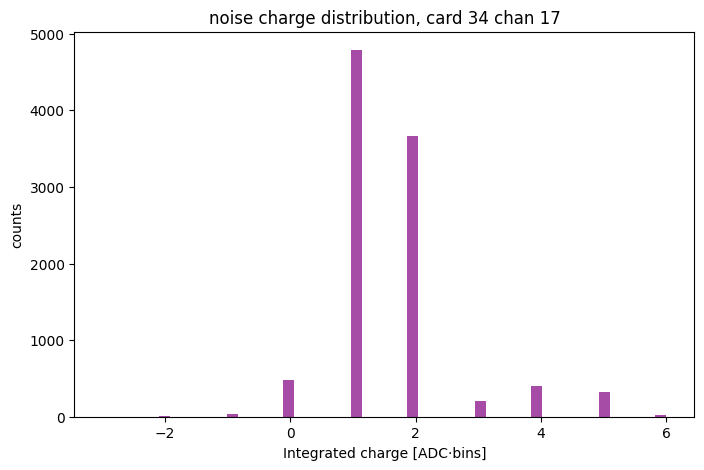

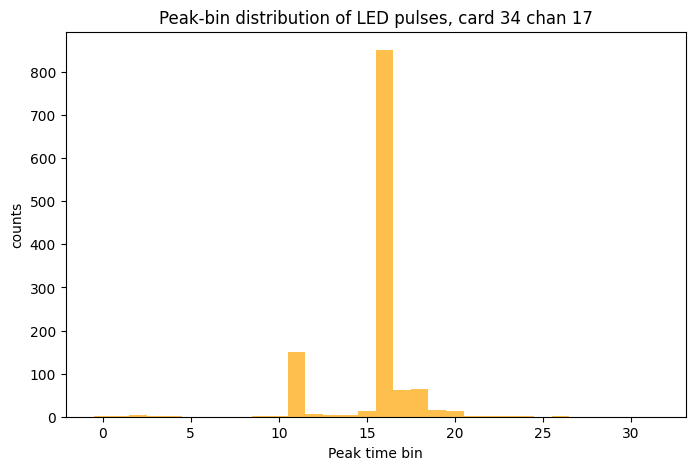

In [157]:
signal_wfs_bs = np.array([gu.baseline_subtract(wf) for wf in signal_wfs])


signal = gu.compute_charges_signal(signal_wfs_bs)
noise = gu.compute_charges_control(noise_wfs)


plt.figure(figsize=(8,5))
plt.hist(signal, bins=100, color='purple', alpha=0.7)
plt.xlabel("Integrated charge [ADC·bins]")
plt.ylabel("counts")
plt.title(f"s.p.e. charge distribution, card {card_id} chan {chan}")
plt.show()

plt.figure(figsize=(8,5))
plt.hist(noise, bins=50, color='purple', alpha=0.7)
plt.xlabel("Integrated charge [ADC·bins]")
plt.ylabel("counts")
plt.title(f"noise charge distribution, card {card_id} chan {chan}")
plt.show()


peak_bins = [np.argmax(wf) for wf in signal_wfs_bs]
plt.figure(figsize=(8,5))
plt.hist(peak_bins, bins=np.arange(waveforms.shape[1]+1)-0.5, color='orange', alpha=0.7)
plt.xlabel("Peak time bin")
plt.ylabel("counts")
plt.title(f"Peak-bin distribution of LED pulses, card {card_id} chan {chan}")
plt.show()

In [158]:
def get_cfd_time(wf):
    """
    Return only the CFD time (fractional bin) for a waveform.
    """
    t, _, _ = gu.get_cfd(wf)
    return t

def align_waveform(wf, t_cfd, ref_bin=50):
    """
    Shift waveform so CFD time lands at ref_bin.
    Uses np.roll with fractional shift (interp).
    """
    shift = int(np.round(ref_bin - t_cfd))
    return np.roll(wf, shift)

In [159]:

signal_wfs_bs = np.array([gu.baseline_subtract(wf) for wf in signal_wfs])
noise_wfs_bs  = np.array([gu.baseline_subtract(wf) for wf in noise_wfs])

cfd_times = np.array([get_cfd_time(wf) for wf in signal_wfs_bs])

#align waveforms
aligned_signal_wfs = np.array([align_waveform(wf, t) for wf, t in zip(signal_wfs_bs, cfd_times) if t > 0])


aligned_signal_wfs = []
for wf in signal_wfs_bs:
    t, _, _ = gu.get_cfd(wf)  # get CFD peak time
    if t > 0:  # valid CFD
        aligned_signal_wfs.append(align_waveform(wf, t))
aligned_signal_wfs = np.array(aligned_signal_wfs)

aligned_noise_wfs = []
for wf in noise_wfs_bs:
    t, _, _ = gu.get_cfd(wf)
    if t > 0:
        aligned_noise_wfs.append(align_waveform(wf, t))
aligned_noise_wfs = np.array(aligned_noise_wfs)

#keep only successful aligned waveforms
print(f"Aligned {len(aligned_signal_wfs)} / {len(signal_wfs_bs)} signal waveforms")
print(f"Aligned {len(aligned_noise_wfs)} / {len(noise_wfs_bs)} signal waveforms")

Aligned 1202 / 1203 signal waveforms
Aligned 9136 / 9924 signal waveforms


In [160]:
signal_charges = gu.compute_charges_signal(aligned_signal_wfs)
noise_charges  = gu.compute_charges_control(noise_wfs_bs)

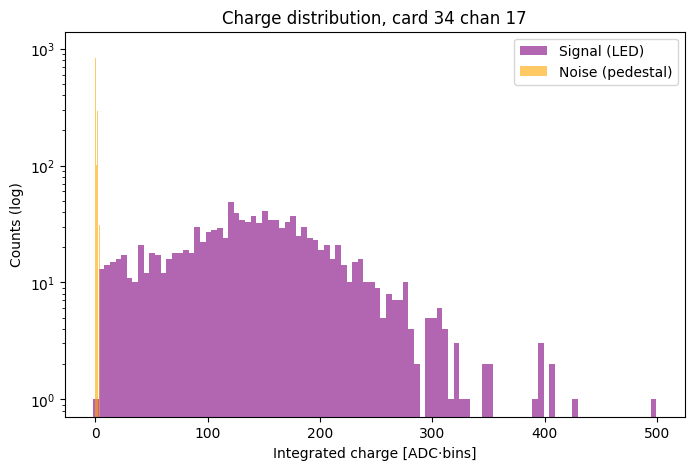

In [162]:
plt.figure(figsize=(8,5))
plt.hist(signal_charges, bins=100, color='purple', alpha=0.6, label="Signal (LED)")
plt.hist(noise_charges, bins=100, color='orange', alpha=0.6, label="Noise (pedestal)")
plt.yscale("log")
plt.xlabel("Integrated charge [ADC·bins]")
plt.ylabel("Counts (log)")
plt.title(f"Charge distribution, card {card_id} chan {chan}")
plt.legend()
plt.show()

In [163]:
fit_results = gu.fit_double_gauss_multistart(signal_charges)
mu1, sigma1 = fit_results['mu1'], fit_results['sigma1']
mu2, sigma2 = fit_results['mu2'], fit_results['sigma2']
w = fit_results['w']


def double_gauss_pdf(x, mu1, sigma1, mu2, sigma2, w):
    return w * norm.pdf(x, mu1, sigma1) + (1-w) * norm.pdf(x, mu2, sigma2)

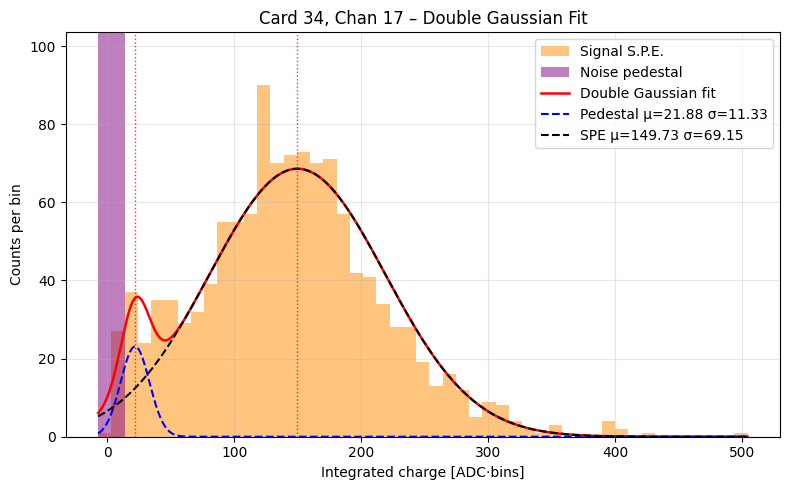

In [164]:
plt.figure(figsize=(8,5))
bins = np.linspace(min(signal_charges.min(), noise_charges.min()) - 5,
                   max(signal_charges.max(), noise_charges.max()) + 5, 50)

# Raw counts
counts, bins_hist, _ = plt.hist(signal_charges, bins=bins, color="darkorange", alpha=0.5, label="Signal S.P.E.", density=False)
plt.hist(noise_charges, bins=bins, color="purple", alpha=0.5, label="Noise pedestal", density=False)

# Overlay fit
bin_width = bins[1] - bins[0]
N = len(signal_charges)
x_vals = np.linspace(bins[0], bins[-1], 2000)

pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
pdf_ped   = w * norm.pdf(x_vals, mu1, sigma1)
pdf_spe   = (1-w) * norm.pdf(x_vals, mu2, sigma2)

pdf_total_counts = pdf_total * N * bin_width
pdf_ped_counts   = pdf_ped * N * bin_width
pdf_spe_counts   = pdf_spe * N * bin_width

plt.plot(x_vals, pdf_total_counts, 'r-', lw=1.8, label="Double Gaussian fit")
plt.plot(x_vals, pdf_ped_counts, 'b--', lw=1.5, label=f"Pedestal μ={mu1:.2f} σ={sigma1:.2f}")
plt.plot(x_vals, pdf_spe_counts, 'k--', lw=1.5, label=f"SPE μ={mu2:.2f} σ={sigma2:.2f}")

# Vertical lines for means
plt.axvline(mu1, color='red', linestyle=':', lw=1, alpha=0.8)
plt.axvline(mu2, color='red', linestyle=':', lw=1, alpha=0.8)

#plt.yscale('log')  # Log scale to better visualize pedestal
plt.ylim(0, np.max(counts)*1.15)
plt.xlabel("Integrated charge [ADC·bins]")
plt.ylabel("Counts per bin")
plt.title(f"Card {card_id}, Chan {chan} – Double Gaussian Fit")
plt.grid(alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.show()

In [152]:
print(f"mu1={mu1:.3f}, sigma1={sigma1:.3f}, mu2={mu2:.3f}, sigma2={sigma2:.3f}, w={w:.3f}")

mu1=30.718, sigma1=11.916, mu2=152.016, sigma2=67.746, w=0.052


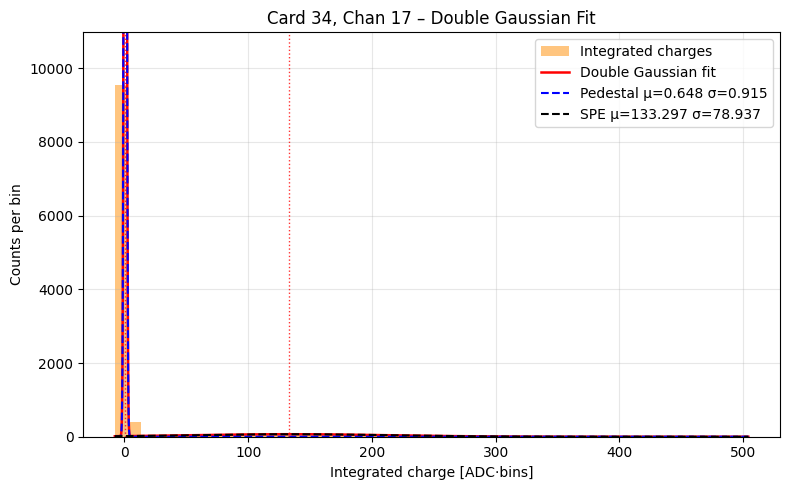

In [167]:
# --------------------------
# Filtrar solo el PMT deseado
# --------------------------
pm_wfs = df_wf[(df_wf["card_id"] == 34) & (df_wf["chan"] == 17)]["samples"].to_numpy()
pm_wfs = np.stack(pm_wfs)  # cada fila = una waveform

# --------------------------
# Baseline subtraction e integración
# --------------------------
signal_wfs_bs = np.array([gu.baseline_subtract(wf) for wf in pm_wfs])
signal_charges = np.array([gu.integrate_waveform_signal(wf) for wf in signal_wfs_bs])

# --------------------------
# Fit doble gaussiano
# --------------------------
fit_results = gu.fit_double_gauss_multistart(signal_charges)
mu1, sigma1 = fit_results["mu1"], fit_results["sigma1"]
mu2, sigma2 = fit_results["mu2"], fit_results["sigma2"]
w = fit_results["w"]

# --------------------------
# Función PDF doble gauss
# --------------------------
def double_gauss_pdf(x, mu1, sigma1, mu2, sigma2, w):
    return w * norm.pdf(x, mu1, sigma1) + (1-w) * norm.pdf(x, mu2, sigma2)

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(8,5))
bins = np.linspace(signal_charges.min() - 5, signal_charges.max() + 5, 50)

# Raw counts
counts, bins_hist, _ = plt.hist(signal_charges, bins=bins, color="darkorange", alpha=0.5, label="Integrated charges", density=False)

# Overlay fit
bin_width = bins[1] - bins[0]
N = len(signal_charges)
x_vals = np.linspace(bins[0], bins[-1], 2000)

pdf_total = double_gauss_pdf(x_vals, mu1, sigma1, mu2, sigma2, w)
pdf_ped   = w * norm.pdf(x_vals, mu1, sigma1)
pdf_spe   = (1-w) * norm.pdf(x_vals, mu2, sigma2)

pdf_total_counts = pdf_total * N * bin_width
pdf_ped_counts   = pdf_ped * N * bin_width
pdf_spe_counts   = pdf_spe * N * bin_width

plt.plot(x_vals, pdf_total_counts, 'r-', lw=1.8, label="Double Gaussian fit")
plt.plot(x_vals, pdf_ped_counts, 'b--', lw=1.5, label=f"Pedestal μ={mu1:.3f} σ={sigma1:.3f}")
plt.plot(x_vals, pdf_spe_counts, 'k--', lw=1.5, label=f"SPE μ={mu2:.3f} σ={sigma2:.3f}")

# Vertical lines for means
plt.axvline(mu1, color='red', linestyle=':', lw=1, alpha=0.8)
plt.axvline(mu2, color='red', linestyle=':', lw=1, alpha=0.8)

plt.ylim(0, np.max(counts)*1.15)
plt.xlabel("Integrated charge [ADC·bins]")
plt.ylabel("Counts per bin")
plt.title(f"Card {card_id}, Chan {chan} – Double Gaussian Fit")
plt.grid(alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.show()

In [168]:
print(f"mu1={mu1:.3f}, sigma1={sigma1:.3f}, mu2={mu2:.3f}, sigma2={sigma2:.3f}, w={w:.3f}")

mu1=0.648, sigma1=0.915, mu2=133.297, sigma2=78.937, w=0.884
